In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [0]:
import importlib
import util
importlib.reload(util)
from util import *

In [0]:
loss = torch.nn.MSELoss()

In [0]:
def train_it(dataset, model, OPTIM=torch.optim.Adam, learning_rate = 1e-1, batch_size=20,Npast=1, Nfuture=1):
    optimizer = OPTIM(model.parameters(), lr=learning_rate)
    Nepoch = 2000

    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Nbatch = batch_size #Ntotal//10
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        y_pred = model(xx)+xx
        L = loss(y_pred,yy)
        h = y_pred
        #for i in range(Nfuture-1):
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss(yyt,yt_pred)
            losses[e//Nsave,0] = L.item()
            losses[e//Nsave,1] = test_err.item()
    return losses

In [0]:
stash = {}

In [11]:
models = {#"PureStencil":PureStencil,
         #"PureLinear":PureLinear,
          "DeepStencil":DeepStencil,
          "LeakyDeepStencil":LeakyDeepStencil,
         "LeakyFCMLP":LeakyFCMLP,
          "FCMLP":FCMLP
         }
for dataname in ["burgers"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    for name, cls in models.items():
        try:
            model =  stash[name]['model']
            disc =   stash[name]['disc']
            results =stash[name]['loss'] 
            print("Resuming training of ",name)
        except KeyError:
            model = cls(Nx).to(device)
            disc = ConditionalDiscriminatorConv(Nx,1).to(device)
            results = np.empty((0,2))
            print("Training new ",name)
        tr_res = train_it(dataset,model,learning_rate=1.0e-2, batch_size=50)
        results = np.append(results, tr_res, axis=0)
        stash[name] = {'model':model,
                       'disc':disc,
                       'loss':results}
    with open(root+f"/data_{dataname}.pkl","wb") as f:
        torch.save(stash,f)

Resuming training of  DeepStencil
1879 0.0017707459628582
3759 0.0017074024071916938
5639 0.0012986169895157218
7519 0.0007676468230783939
9399 0.0011143451556563377
11279 0.003278842894360423
13159 0.0013363090110942721
15039 0.0009363745339214802
16919 0.0007353890687227249
18799 0.00153332797344774
Resuming training of  LeakyDeepStencil
1879 0.0006128240493126214
3759 0.0011072721099480987
5639 0.0032095173373818398
7519 0.0011770385317504406
9399 0.0010488324332982302
11279 0.0024106132332235575
13159 0.0020001160446554422
15039 0.0017073455965146422
16919 0.0010121812811121345
18799 0.001032601692713797
Resuming training of  LeakyFCMLP
1879 0.004855628125369549
3759 0.006367105524986982
5639 0.0024419601541012526
7519 0.00274330610409379
9399 0.003728654934093356
11279 0.003732153447344899
13159 0.005345641635358334
15039 0.00331251067109406
16919 0.003536139614880085
18799 0.0033333655446767807
Resuming training of  FCMLP
1879 0.005925128702074289
3759 0.005596300587058067
5639 0

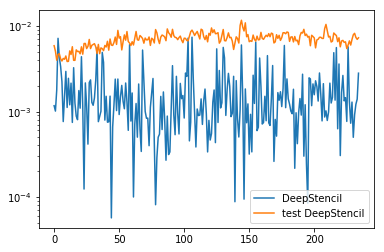

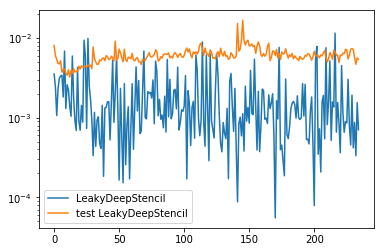

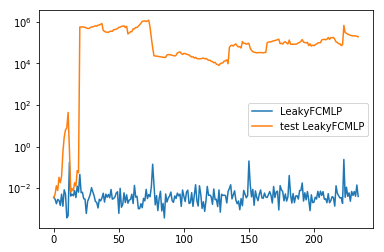

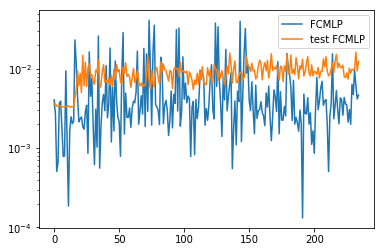

In [8]:
for N,S in stash.items():
    plt.semilogy(S['loss'][:,0],label=N)
    plt.semilogy(S['loss'][:,1],label=f"test {N}")
    plt.legend()
    plt.show()

DeepStencil


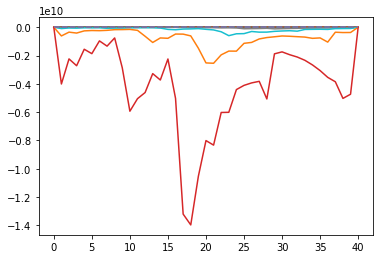

LeakyDeepStencil


/content/drive/My Drive/Colab Notebooks/burgers/util.py:224: RuntimeWarning: overflow encountered in true_divide
  errors[i] = np.linalg.norm((ucpu - dcpu)/(np.abs(dcpu)+1.0e-5))


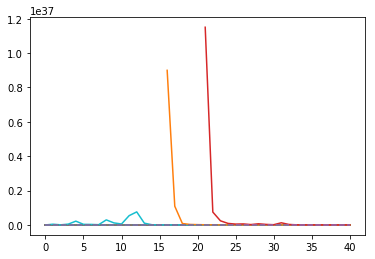

LeakyFCMLP


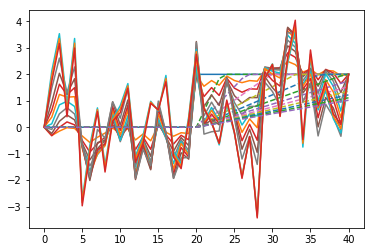

FCMLP


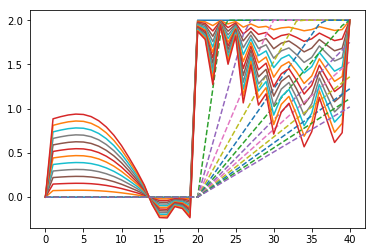

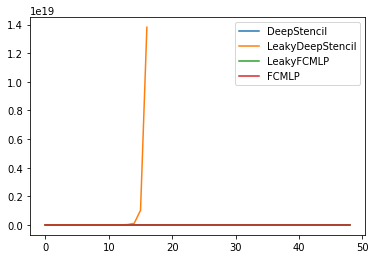

DeepStencil


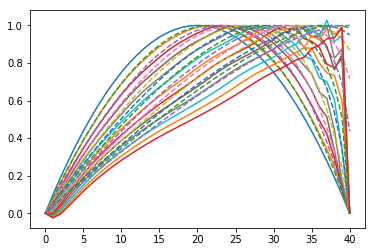

LeakyDeepStencil


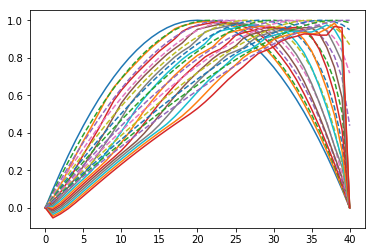

LeakyFCMLP


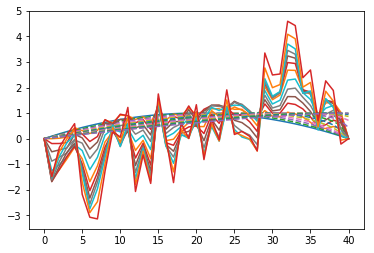

FCMLP


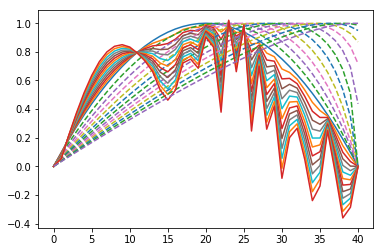

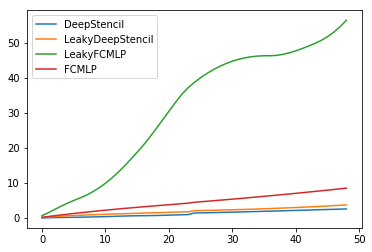

In [12]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,0)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()